In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


# PREPROCESSING DATA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/Silver Futures Historical Data.csv')
df = df[['Price']]
# Flip the column
df = df.iloc[::-1]

# Drop missing values
df = df.dropna()

# Reset the index
df = df.reset_index(drop=True)

# SPLITTING DATA(7-2-1)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
!pip install pmdarima --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.9 MB/s eta 0:00:00


In [ ]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', stepwise=True, suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1306.331, Time=8.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1310.662, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1303.515, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1304.333, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1308.811, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1303.776, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1304.388, Time=1.75 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1305.754, Time=3.67 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1301.699, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1301.944, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1302.565, Time=0.62 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1302.516, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1303.921, Time=1.22 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 18.440 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[23.87936011 23.87689781 23.87714669 23.87712154 23.87712408 23.87712382
 23.87712385 23.87712384 23.87712385 23.87712385 23.87712385 23.87712385
 23.87712385 23.87712385 23.87712385 23.87712385 23.87712385 23.87712385
 23.87712385 23.87712385 23.87712385 23.87712385 23.87712385 23.87712385
 23.87712385 23.87712385 23.87712385 23.87712385 23.87712385 23.87712385]


In [ ]:
# Calculate the accuracy for each model

from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  1.7987116593987025
Testing MAE:  1.2733602837494304
Testing MAPE:  5.045029439612044
Validation RMSE:  6.822583984722134
Validation MAE:  6.6112302416095154
Validation MAPE:  21.44650797337738


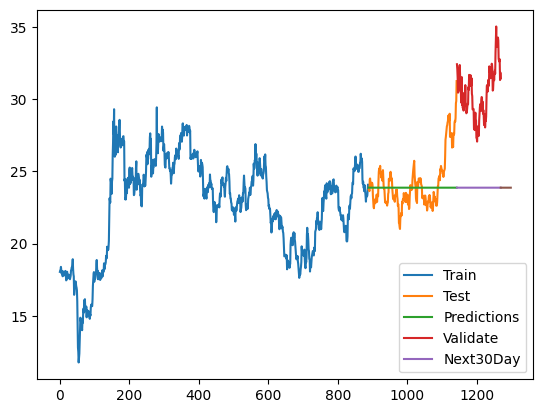

In [ ]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Price'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  889
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -648.849
Date:                Sun, 17 Nov 2024   AIC                           1301.699
Time:                        12:59:40   BIC                           1311.276
Sample:                             0   HQIC                          1305.360
                                - 889                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1011      0.022     -4.660      0.000      -0.144      -0.059
sigma2         0.2525      0.006     40.219      0.000       0.240       0.265
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1352.58
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SPLITTING DATA(6-3-1)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1167.815, Time=1.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1176.377, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1168.973, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1170.038, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1174.527, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1169.822, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1170.370, Time=0.69 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1166.568, Time=2.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1169.587, Time=3.51 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1173.488, Time=2.90 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1170.688, Time=2.45 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1169.643, Time=1.88 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1169.389, Time=0.78 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=1171.060, Time=1.94 sec
 ARIMA(3,1,2)(0,0,0)[0]          

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[23.52433892 23.57087823 23.60621876 23.53959222 23.55200534 23.6069214
 23.55694141 23.53929653 23.59920614 23.57441766 23.53451403 23.58586512
 23.588244   23.53763059 23.57051758 23.59593261 23.54692345 23.55673217
 23.59664736 23.5595708  23.54726607 23.59116363 23.57240523 23.54358001
 23.58148682 23.58264106 23.54569682 23.5702571  23.58842274 23.55238803]


In [ ]:
# Calculate accurary for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  1.7355123236704155
Testing MAE:  1.213360246447644
Testing MAPE:  4.89889583651331
Validation RMSE:  7.122527181612441
Validation MAE:  6.92030949142406
Validation MAPE:  22.463335448133673


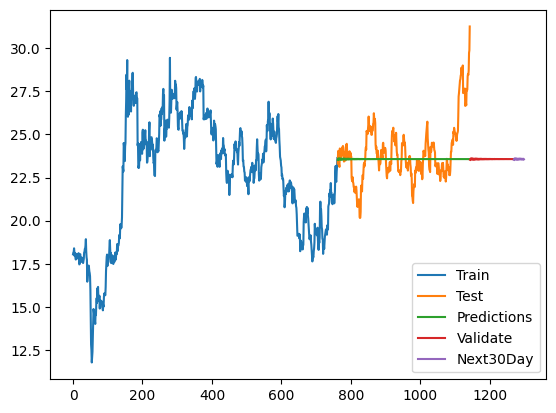

In [ ]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

# SPLITTING DATA(5-3-2)

In [ ]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [ ]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1009.629, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1024.318, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1015.138, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1016.346, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1022.399, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1016.932, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1017.357, Time=0.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.83 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1015.154, Time=1.94 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1016.030, Time=0.43 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1017.124, Time=0.82 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1017.022, Time=1.16 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1012.379, Time=5.84 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1007.717, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[21.91122781 22.00098887 21.91313869 21.88869336 21.98323328 21.94879091
 21.88306507 21.9540656  21.97146727 21.89609768 21.92550007 21.97672606
 21.91905052 21.90689369 21.96692861 21.94195036 21.90208347 21.94888561
 21.95719495 21.90941343 21.9305425  21.9615215  21.92358149 21.91806963
 21.95606767 21.93826282 21.91422932 21.94495486 21.94845442 21.91826154]


In [ ]:
# Calculate accuracy for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) * 100
val_mape = np.mean(val_ape) * 100

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  2.1204700719776874
Testing MAE:  1.8467167876928658
Testing MAPE:  8.420555477141917
Validation RMSE:  6.679906601446171
Validation MAE:  5.757917925167796
Validation MAPE:  19.56672272721265


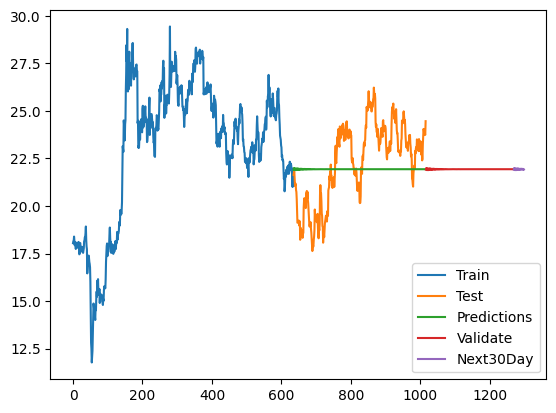

In [ ]:
# Plot
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()